In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

#  TODO 

## Hyper parameter share information only with particular timezone
Timezones : Morning(7 to)

# Reading Location Names

In [3]:
aruba_dataset_path = '/data/dataDeebul/thesis/dataset/strands/aruba/locations.names'

location_names = {}
count = 0
with open(aruba_dataset_path, 'r') as content_file:
    content = content_file.read()
    content = str.splitlines(content)
for count,location in enumerate(content):
    location_names[count] = location
print(location_names)


{0: 'Master bedroom', 1: 'Master bathroom', 2: 'Living room', 3: 'Kitchen', 4: 'Center', 5: 'Corridor', 6: 'Second bedroom', 7: 'Office', 8: 'Second bathroom', 9: 'Outside'}


# Reading location data

In [ ]:
aruba_dataset_path = '/data/dataDeebul/thesis/dataset/strands/aruba/locations.min'

dataset = pd.read_csv(aruba_dataset_path, names=['location', 'time'])
dataset['time'] = dataset.index
dataset['time'] = pd.to_timedelta(dataset['time'], unit='m')
dataset['day'] = (dataset['time']/ np.timedelta64(1, 'D')).astype(int)
dataset['hour'] = (dataset['time']/ np.timedelta64(1, 'h')).astype(int)
def mod_for_hour(row):
    return row['hour'] % 24
dataset['sep_hour'] = dataset.apply(mod_for_hour, axis=1)
dataset['time of day'] = dataset.apply(mod_for_hour, axis=1)


In [16]:
#Renaming location number with their names
for key,value in location_names.items():
    dataset.ix[dataset.location == key, 'location_name'] = value


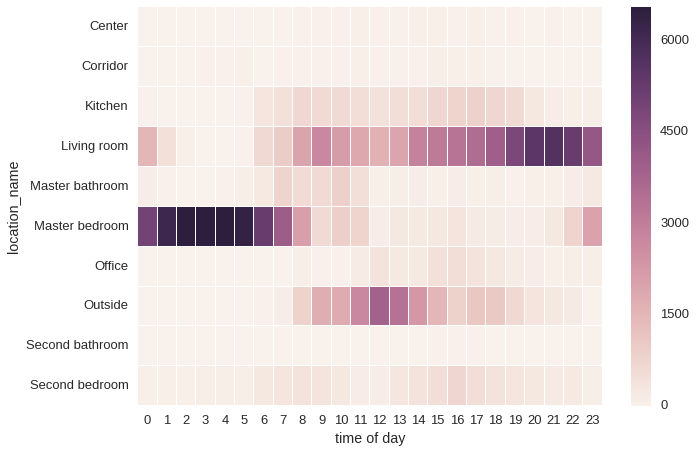

In [23]:
import matplotlib.pyplot as plt
hour_vs_location = pd.crosstab(dataset['location_name'], 
                               dataset['time of day'])

sns.set_context('talk')
sns.set_style('darkgrid')
sns.heatmap(hour_vs_location, linewidths=.01)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


# Reducing the dataset

The ARUBA dataset is a well
Since we have 112 days per minute readings (161280 readings). We will create reduced datasets with the
following assumptions 
    - 3 readings every day ( 112 * 3 = 336) 
    - 5 readings everyday (112 * 5 = 560) 
    - 10 readings everyday (112 * 10 = 1120)


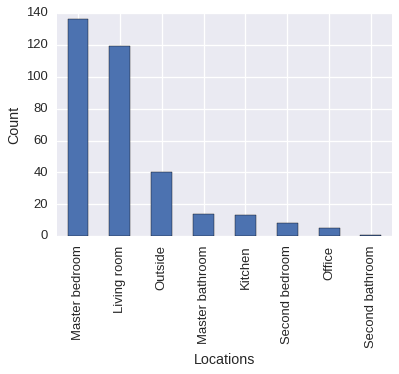

In [18]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
rows = random.sample(list(dataset.index), 336)
reduced_dataset_3readings = dataset.ix[rows]
rows = random.sample(list(dataset.index), 560)
reduced_dataset_5readings = dataset.ix[rows]
rows = random.sample(list(dataset.index), 1120)
reduced_dataset_10readings = dataset.ix[rows]

ax = (reduced_dataset_3readings['location_name'].value_counts()).plot(kind='bar')
ax.set_xlabel("Locations")
ax.set_ylabel("Count")

In [19]:
reduced_dataset_3readings.set_index(np.arange(reduced_dataset_3readings.shape[0]), inplace=True)

# Some Data Analysis

In [24]:
hour_vs_location = pd.crosstab(reduced_dataset_10readings['location_name'], 
                               reduced_dataset_10readings['time of day'])

In [26]:
%matplotlib qt
sns.set_context('talk')
sns.set_style('darkgrid')
sns.heatmap(hour_vs_location, linewidths=.01 )
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


# Model Based Machine Lerning

Creating Hierarchical Model
![Hierarchical Model](images/hierarchicalmodel.png)

In [10]:
#Some constants
n_locations = len(location_names.values())
n_timezones = 24
#n_trials = reduced_dataset_3readings.shape[0]
n_trials = 50

from bayespy import nodes
p_theta = nodes.Dirichlet(np.ones(n_locations)*0.1,
                          plates=(n_timezones,),
                          name='p_theta')

#Taking readings of sep_hour as we know the time in which the reading was taken
#Reshaing it meet th plates
recordings_time = reduced_dataset_3readings.ix[:n_trials-1, 'sep_hour'].as_matrix().reshape((n_trials, 1))

Y = nodes.Mixture(recordings_time, nodes.Categorical, p_theta)

# Observe Data

In [11]:
Y.observe(reduced_dataset_3readings.ix[:n_trials-1, 'location'].reshape((n_trials, 1)))

# Inference

In [15]:
from bayespy.inference import VB
Q = VB(Y, p_theta)
Q.update(repeat=1000)

Iteration 1: loglike=-9.776030e+01 (0.002 seconds)
Iteration 2: loglike=-9.776030e+01 (0.001 seconds)
Converged at iteration 2.


In [16]:
np.array(Y.get_parameters()).shape

(1, 50, 1, 10)

In [17]:
learned_params = np.array(p_theta.get_parameters()).reshape((24,10))

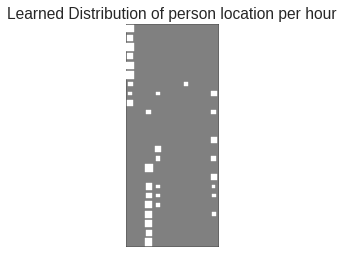

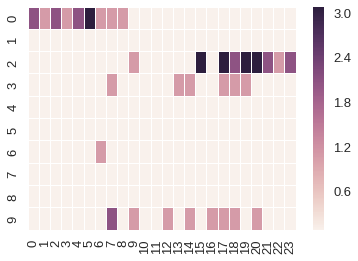

In [18]:
%matplotlib inline
import bayespy.plot as bpplt
bpplt.hinton(p_theta)
bpplt.pyplot.title("Learned Distribution of person location per hour")
bpplt.pyplot.show()

sns.heatmap(learned_params.T, linewidths=.01)


In [ ]:
#Some constants
n_locations = len(location_names.values())
n_timezones = 24
#n_trials = reduced_dataset_3readings.shape[0]
n_trials = 300

from bayespy import nodes
p_conc = nodes.DirichletConcentration(n_locations)
p_conc.initialize_from_value(np.ones(n_locations))
p_theta = nodes.Dirichlet(p_conc,
                          plates=(n_timezones,),
                          name='p_theta')
recordings_time = reduced_dataset_3readings.ix[:n_trials-1, 'sep_hour'].as_matrix().reshape((n_trials, 1))

Y = nodes.Mixture(recordings_time, nodes.Categorical, p_theta)

#Observe Data
Y.observe(reduced_dataset_3readings.ix[:n_trials-1, 'location'].reshape((n_trials, 1)))

#Inference
Q = VB(Y, p_theta, p_conc)
Q.update(repeat=1000)

#Evaluation
learned_params = np.array(p_theta.get_parameters()).reshape((24,10))
sns.heatmap(learned_params.T, linewidths=.01)


In [ ]:
bpplt.hinton(p_theta)
bpplt.pyplot.title("Learned Distribution of person location per hour")
bpplt.pyplot.show()

In [ ]:
# Some constatnts we will be using 

n_colors = 5 #Number of colors in each bag
n_bags = 3 # Number of bags
n_trials = 10
from bayespy.nodes import DirichletConcentration
from bayespy import nodes
import numpy as np

p_conc = DirichletConcentration(n_colors)
p_theta = nodes.Dirichlet(p_conc,
                          plates=(n_bags,),
                          name='p_theta')

bag_model = nodes.Categorical(p_theta,
                        plates=(n_trials, n_bags),
                        name='bag_model')
bag_model.plates

In [30]:

dataset.shape

np.zeros(n_observations, dtype=int)

array([0, 0, 0, ..., 0, 0, 0])

# Latent Dirichlet allocation


Tried form the LDA example of bayespy 

Distibution of words in topics => distibution of person in different locations
Distribution of topics in documents => distribution of locations

n_document = 1 => since we have only 1 home readings
n_topics = n_locations
n_timezone = n_vocabulary 



In [47]:
p_topic = nodes.Dirichlet(np.ones(n_timezones),
                           plates=(1,),
                           name='p_topic')
n_observations = dataset.shape[0]
n_documents = 1
p_word = nodes.Dirichlet(np.ones(n_locations),
                          plates=(n_timezones,),
                          name='p_word')

from bayespy.inference.vmp.nodes.categorical import CategoricalMoments
document_indices = nodes.Constant(CategoricalMoments(n_documents), np.zeros(n_observations, dtype=int),
                                   name='document_indices')

topics = nodes.Categorical(nodes.Gate(document_indices, p_topic),
                            plates=(n_observations,),
                            name='topics')

words = nodes.Categorical(nodes.Gate(topics, p_word),
                           name='words')

words.observe(dataset['location'])

In [48]:
p_topic.initialize_from_random()
p_word.initialize_from_random()


In [49]:
from bayespy.inference import VB
Q = VB(words, topics, p_word, p_topic, document_indices)
Q.update(repeat=1000)

Iteration 1: loglike=-2.494288e+05 (1.047 seconds)
Iteration 2: loglike=-2.494244e+05 (0.865 seconds)
Iteration 3: loglike=-2.494214e+05 (1.114 seconds)
Iteration 4: loglike=-2.494189e+05 (1.104 seconds)
Converged at iteration 4.


In [50]:
import bayespy.plot as bpplt


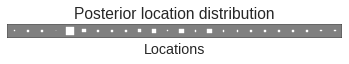

In [51]:
bpplt.pyplot.figure()
>>> bpplt.hinton(Q['p_topic'])
>>> bpplt.pyplot.title("Posterior location distribution")
>>> bpplt.pyplot.xlabel("Locations")
>>> bpplt.pyplot.ylabel("")

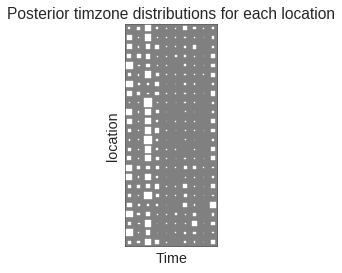

In [52]:
bpplt.pyplot.figure()
>>> bpplt.hinton(Q['p_word'])
>>> bpplt.pyplot.title("Posterior timzone distributions for each location")
>>> bpplt.pyplot.xlabel("Time")
>>> bpplt.pyplot.ylabel("location")

# Bernoulli mixture model
Tried mixing the bernoulli mixture for different datatype
but it cannot be done because we learn pattern in different 

In [3]:
N = 100
>>> D = 10
>>> K = 10
>>> from bayespy.nodes import Categorical, Dirichlet
>>> R = Dirichlet(K*[1e-5],
...               name='R')
>>> Z = Categorical(R,
...                 plates=(N,1),
...                 name='Z')

>>> from bayespy.nodes import Beta
>>> P = Beta([0.5, 0.5],
...          plates=(D,K),
...          name='P')
>>> from bayespy.nodes import Mixture, Bernoulli
>>> X = Mixture(Z, Bernoulli, P)

from bayespy.utils import random
import numpy as np
z = random.categorical(np.ones(D)*(1/D), size=100)

Y = Mixture(z, Bernoulli, X)

NoConverterError: No conversion defined from BernoulliMoments to BetaMoments